<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### **Read synthetic population data**

In [95]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_people = 'franklin/microdata/franklin_people_all.csv'
data_people = pd.read_csv(filename_people)
data_people['GEOID10'] = data_people['GEOID10'].astype(str)
data_people['BGID10'] = data_people['GEOID10'].str[:12]
data_people['TRACTID10'] = data_people['GEOID10'].str[:11]
data_people

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,race,sex,age,age_v,PUMA,BGID10,TRACTID10
0,390490001101001,1,1,9,28,3904102,390490001101,39049000110
1,390490001101001,7,2,9,27,3904102,390490001101,39049000110
2,390490001101002,1,2,1,0,3904102,390490001101,39049000110
3,390490001101002,1,2,1,3,3904102,390490001101,39049000110
4,390490001101002,1,2,2,7,3904102,390490001101,39049000110
...,...,...,...,...,...,...,...,...
1163409,390490107001020,1,2,21,75,3904102,390490107001,39049010700
1163410,390490107001020,1,1,23,95,3904102,390490107001,39049010700
1163411,390490107001020,1,2,23,97,3904102,390490107001,39049010700
1163412,390499800001027,1,1,20,70,3904106,390499800001,39049980000


#### **Create original histograms**
We consider the query of race for the purpose of demonstration. Cell uniqueness is presented in this query.

In [3]:
hist1 = pd.crosstab(data_people.GEOID10, data_people.race)
hist1

race,1,2,3,4,5,6,7
GEOID10,,,,,,,
390490001101001,1,0,0,0,0,0,1
390490001101002,45,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0
390490001101005,51,0,0,0,0,0,4
...,...,...,...,...,...,...,...
390490107001015,92,17,0,0,0,1,2
390490107001016,9,0,0,0,0,0,0
390490107001017,42,6,0,9,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

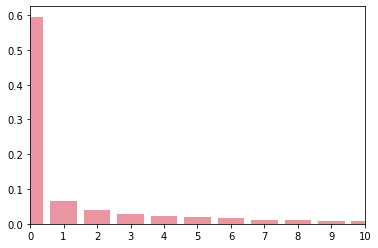

In [ ]:
import seaborn as sns

probabilities = hist1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

#### **Add noises (Zero-concentrated differential privacy)**
There are two core components to the 2020 DAS: noise injection and post-processing. We only focus on the noise injection here. Consistent with the 2020 DAS, discrete Gaussian noise is applied.

Bun, M., & Steinke, T. (2016, November). Concentrated differential privacy: Simplifications, extensions, and lower bounds. In Theory of Cryptography Conference (pp. 635-658). Springer, Berlin, Heidelberg.

Parameters for generating Gaussian noise.

In [150]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0, sigma

(0.03765194044422748, 1.8998742342553376, 3.6441086797038675)

Probability of generating zero noise and other noises.

In [ ]:
import scipy.stats

print(scipy.stats.norm(0, sigma).cdf(0.5) - scipy.stats.norm(0, sigma).cdf(-0.5), 
      scipy.stats.norm(0, sigma).cdf(1.5) - scipy.stats.norm(0, sigma).cdf(0.5),
      scipy.stats.norm(0, sigma).cdf(2.5) - scipy.stats.norm(0, sigma).cdf(1.5),
      scipy.stats.norm(0, sigma).cdf(3.5) - scipy.stats.norm(0, sigma).cdf(2.5), 
      scipy.stats.norm(0, sigma).cdf(8.5) - scipy.stats.norm(0, sigma).cdf(7.5))

0.10913342502468493 0.1051255079831912 0.09396346340685724 0.07793101600369479 0.009953116866908474


Add noise to histogram.

In [ ]:
hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
hist2

race,1,2,3,4,5,6,7
GEOID10,,,,,,,
390490001101001,3.0,-3.0,-3.0,-2.0,-6.0,-4.0,1.0
390490001101002,50.0,-3.0,4.0,-2.0,-1.0,3.0,-6.0
390490001101003,51.0,5.0,3.0,3.0,-3.0,5.0,2.0
390490001101004,44.0,1.0,-2.0,-1.0,-1.0,-3.0,-3.0
390490001101005,57.0,0.0,-2.0,0.0,4.0,1.0,10.0
...,...,...,...,...,...,...,...
390490107001015,92.0,23.0,-5.0,4.0,-4.0,8.0,6.0
390490107001016,10.0,5.0,-5.0,-4.0,-6.0,4.0,-5.0
390490107001017,41.0,2.0,3.0,5.0,-7.0,1.0,4.0


####**Cell uniqueness**
Young, C., Martin, D., & Skinner, C. (2009). Geographically intelligent disclosure control for flexible aggregation of census data. International Journal of Geographical Information Science, 23(4), 457-482.

Privacy measure: probability of finding a true unique

In [ ]:
# find a true unique
tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
n_tu

795

In [ ]:
# uniques after noise injection
u = hist2 == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
n_u

8362

In [ ]:
# frequency of finding the true uniques
p_tu = n_tu / n_u
p_tu

0.09507294905524993

Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

$p(TU)=\frac{p(-0.5<=W<=0.5)p(A_1)}{\sum_ip(0.5-i<=W<=1.5-i)p(A_i)}$


$p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [151]:
import scipy.stats

column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.08792193110751202

We also use a Monte Carlo method to calculate the expected frequency (probability) of finding the true uniques. The result is consistent with the theoretical value.

In [ ]:
import statistics
import numpy as np

N = 1000    # bootstrap times
p_tus = []

for i in range(N):
    hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
    # find a true unique
    tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2 == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu = n_tu / n_u
    p_tus.append(p_tu)

statistics.mean(p_tus)

0.08784854985966403

Compare with the Privacy-Protected 2010 Census Demonstration Data derived from the 2021-06-08 vintage of the PPMF. The result shows that after post-processing, the $p(TU)$ is potentially larger than that calculated immediately after noise injection.

In [98]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_nhgis = n_tu / n_u
p_tu_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.11636167922497309

We also compare the results with that derived in the Guernsey county, which only has a population of 40,087.

In [99]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns

filename_people_g = 'guernsey/microdata/guernsey_people_all.csv'
data_people_g = pd.read_csv(filename_people_g)
data_people_g['GEOID10'] = data_people_g['GEOID10'].astype(str)
data_people_g['BGID10'] = data_people_g['GEOID10'].str[:12]
data_people_g['TRACTID10'] = data_people_g['GEOID10'].str[:11]
data_people_g.head()

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,race,sex,age,age_v,BGID10,TRACTID10
0,390599771001005,1,1,1,1,390599771001,39059977100
1,390599771001005,1,1,1,1,390599771001,39059977100
2,390599771001005,1,1,1,2,390599771001,39059977100
3,390599771001005,1,1,1,0,390599771001,39059977100
4,390599771001005,1,1,1,2,390599771001,39059977100


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

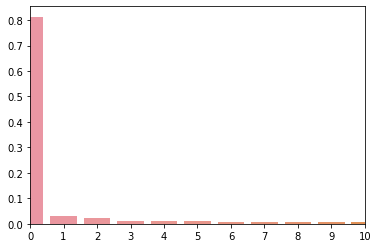

In [100]:
import seaborn as sns

hist1_g = pd.crosstab(data_people_g.GEOID10, data_people_g.race)
probabilities = hist1_g.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [101]:
import scipy.stats

column_values = hist1_g[hist1_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_g = p3 * p4 / sum(probs)
p_tu_g

0.03317121400234159

In [102]:
# compare with NHGIS
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_block_g = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block_g = pd.read_csv(filename_nhgis_block_g)

hist1_nhgis_g = nhgis_block_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_g = hist1_nhgis_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_g = nhgis_block_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_g = hist2_nhgis_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_g == hist2_nhgis_g) & (hist1_nhgis_g == 1) & (hist2_nhgis_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_nhgis_g = n_tu / n_u
p_tu_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.05958132045088567

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of resolutions (aggregation levels)**
We test the probability of finding a true unique at both block group and tract levels. As shown below, as we increase the aggregation level, the probability raises. This is potentially due to the fact that the histogram is less clustered around the small numbers (e.g., 2, 3, 0 that are easily transformed to 1 when adding noises).

######**Block group**

In [103]:
hist1_bg = pd.crosstab(data_people.BGID10, data_people.race)
hist1_bg

race,1,2,3,4,5,6,7
BGID10,,,,,,,
390490001101,1040,14,0,8,0,3,15
390490001102,814,15,0,18,0,3,7
390490001103,619,6,2,6,0,6,9
390490001104,744,5,0,4,0,1,5
390490001201,758,6,0,11,0,2,12
...,...,...,...,...,...,...,...
390490106021,1369,48,4,41,0,17,31
390490106022,2293,59,1,159,0,17,45
390490106023,1824,50,4,220,0,20,37


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

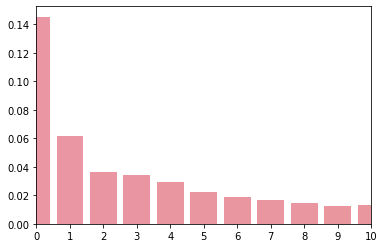

In [ ]:
import seaborn as sns

probabilities = hist1_bg.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [104]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 3/4099

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0, sigma

(0.012544523054403513, 1.0874367368840445, 6.313321779713481)

In [105]:
import scipy.stats

column_values = hist1_bg[hist1_bg.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_bg = p3 * p4 / sum(probs)
p_tu_bg

0.1661838820385404

In [106]:
# Compare with NHGIS data
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_bg = 'franklin/nhgis/franklin_nhgis_bg.csv'
nhgis_bg = pd.read_csv(filename_nhgis_bg)

hist1_nhgis_bg = nhgis_bg[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_bg = nhgis_bg[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_bg == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_bg_nhgis = n_tu / n_u
p_tu_bg_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.2316715542521994

Compare with Guernsey county.

In [107]:
import scipy.stats

hist1_bg_g = pd.crosstab(data_people_g.BGID10, data_people_g.race)
column_values = hist1_bg_g[hist1_bg_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_bg_g = p3 * p4 / sum(probs)
p_tu_bg_g

0.201244639220228

In [108]:
# Compare with NHGIS data (Guernsey)
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_bg_g = 'guernsey/nhgis/guernsey_nhgis_bg.csv'
nhgis_bg_g = pd.read_csv(filename_nhgis_bg_g)

hist1_nhgis_bg_g = nhgis_bg_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg_g = hist1_nhgis_bg_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_bg_g = nhgis_bg_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg_g = hist2_nhgis_bg_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_bg_g == hist2_nhgis_bg_g) & (hist1_nhgis_bg_g == 1) & (hist2_nhgis_bg_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_bg_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_bg_nhgis_g = n_tu / n_u
p_tu_bg_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.3448275862068966

######**Tract**

In [109]:
hist1_tr = pd.crosstab(data_people.TRACTID10, data_people.race)
hist1_tr

race,1,2,3,4,5,6,7
TRACTID10,,,,,,,
39049000110,3217,40,2,36,0,13,36
39049000120,3016,44,3,42,1,7,49
39049000210,2773,52,5,32,0,10,63
39049000220,3536,32,4,55,0,24,76
39049000310,2135,739,3,70,2,61,137
...,...,...,...,...,...,...,...
39049010500,6499,108,4,1179,1,43,119
39049010601,3933,128,3,453,0,32,95
39049010602,5486,157,9,420,0,54,113


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

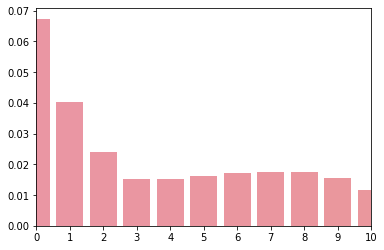

In [ ]:
import seaborn as sns

probabilities = hist1_tr.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [110]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 4/2051

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0, sigma

(0.03342759629449049, 1.7880772470489288, 3.867518750251543)

In [111]:
import scipy.stats

column_values = hist1_tr[hist1_tr.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_tr = p3 * p4 / sum(probs)
p_tu_tr

0.22091171504653892

In [112]:
# Compare with NHGIS data
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_tr = 'franklin/nhgis/franklin_nhgis_tract.csv'
nhgis_tr = pd.read_csv(filename_nhgis_tr)

hist1_nhgis_tr = nhgis_tr[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_tr = nhgis_tr[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_tr == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_tr_nhgis = n_tu / n_u
p_tu_tr_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.18181818181818182

Compare with Guernsey county.

In [113]:
import scipy.stats

hist1_tr_g = pd.crosstab(data_people_g.TRACTID10, data_people_g.race)
column_values = hist1_tr_g[hist1_tr_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_tr_g = p3 * p4 / sum(probs)
p_tu_tr_g

0.2296246783029495

In [114]:
# Compare with NHGIS data (Guernsey)
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_tr_g = 'guernsey/nhgis/guernsey_nhgis_tract.csv'
nhgis_tr_g = pd.read_csv(filename_nhgis_tr_g)

hist1_nhgis_tr_g = nhgis_tr_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr_g = hist1_nhgis_tr_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_tr_g = nhgis_tr_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr_g = hist2_nhgis_tr_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_tr_g == hist2_nhgis_tr_g) & (hist1_nhgis_tr_g == 1) & (hist2_nhgis_tr_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_tr_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_tr_nhgis_g = n_tu / n_u
p_tu_tr_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.5

We can plot the $p(TU)$ under different aggregation levels using a bar chart.

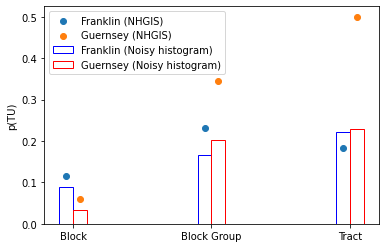

In [115]:
import matplotlib.pyplot as plt

labels = ['Block', 'Block Group', 'Tract']
p_tu_1 = [p_tu, p_tu_bg, p_tu_tr]
p_tu_2 = [p_tu_nhgis, p_tu_bg_nhgis, p_tu_tr_nhgis]
p_tu_3 = [p_tu_g, p_tu_bg_g, p_tu_tr_g]
p_tu_4 = [p_tu_nhgis_g, p_tu_bg_nhgis_g, p_tu_tr_nhgis_g]

x = np.arange(len(labels))  # the label locations
width = 0.1 # the width of the bars

fig, ax = plt.subplots()
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]

rects1 = ax.bar(x - 0.5 * width, p_tu_1, width, label='Franklin (Noisy histogram)', color=(0,0,0,0), edgecolor=colors[0])
rects3 = ax.bar(x + 0.5 * width, p_tu_3, width, label='Guernsey (Noisy histogram)', color=(0,0,0,0), edgecolor=colors[1])
rects2 = ax.scatter(x - 0.5 * width, p_tu_2, label='Franklin (NHGIS)')
rects4 = ax.scatter(x + 0.5 * width, p_tu_4, label='Guernsey (NHGIS)')

ax.set_ylabel('p(TU)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

#####**Impact of extents**

Read block and tract data.

In [ ]:
!pip install geopandas
!pip install pysal

In [116]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]
data_block.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID_1', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'PUMA',
       'Shape_Length', 'Shape_Area', 'BGID10', 'TRACTID10', 'geometry'],
      dtype='object')

In [117]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract = 'franklin/buildings/franklin_tract10.json'
data_tract = gpd.read_file(filename_tract)
data_tract['GEOID10'] = data_tract['GEOID10'].astype(str)
data_tract.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

######**Continuous neighbors**

Find blocks in the most populated tract (largest population density).

In [118]:
total = hist1_tr.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
39049000110,3344,39049000110
39049000120,3162,39049000120
39049000210,2935,39049000210
39049000220,3727,39049000220
39049000310,3147,39049000310


In [119]:
data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(232, '39049001810')

Calculate $p(TU)$ based on the selected blocks (only blocks in the most population tract).

In [120]:
data_people_b1 = data_people[data_people["TRACTID10"] == max_id]
hist1_b1 = pd.crosstab(data_people_b1.GEOID10, data_people_b1.race)
hist1_b1.head()

race,1,2,3,4,6,7
GEOID10,,,,,,
390490018101000,88,5,0,7,2,4
390490018101001,45,0,0,8,0,1
390490018101002,338,25,0,53,6,15
390490018101003,153,4,0,30,0,5
390490018101004,234,7,0,40,0,6


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

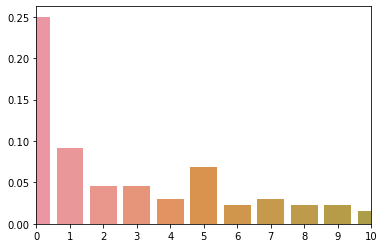

In [49]:
import seaborn as sns

probabilities = hist1_b1.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [128]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0, sigma

(0.03765194044422748, 1.8998742342553376, 3.6441086797038675)

In [123]:
import scipy.stats

column_values = hist1_b1[hist1_b1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_b1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_b1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.18278672381416478

Expand the examined blocks by considering the neighbors of the most populated tract based on Rook continuity.

In [124]:
import geopandas as gpd
from pysal.lib import weights

k10 = weights.Rook.from_dataframe(data_tract)
nb_index = k10.neighbors[max_index]
nb_id = data_tract["GEOID10"].iloc[nb_index]
nb_id

233    39049001700
35     39049001122
126    39049001121
231    39049001820
Name: GEOID10, dtype: object

In [125]:
data_people_b2 = data_people[data_people["TRACTID10"].isin(nb_id)]
hist1_b2 = pd.crosstab(data_people_b2.GEOID10, data_people_b2.race)
hist1_b2.head()

race,1,2,3,4,5,6,7
GEOID10,,,,,,,
390490011211002,1900,110,5,113,0,27,6
390490011212000,486,14,0,91,0,3,1
390490011212001,5,1,0,0,0,0,0
390490011212003,1779,90,7,125,0,27,5
390490011213000,13,0,0,10,0,0,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

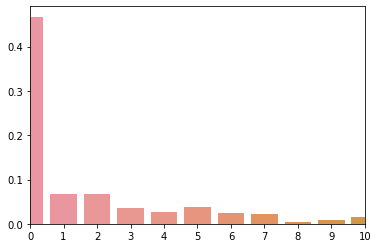

In [ ]:
import seaborn as sns

probabilities = hist1_b2.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [129]:
import scipy.stats

column_values = hist1_b2[hist1_b2.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_b2 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_b2 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.09916652833582495

We can keep searching the neighbors based on Rook continuity until all blocks in the county are covered. 

In [130]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_all = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    data_people_sub = data_people[data_people["TRACTID10"].isin(tract_ids)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all.append(p_tu)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_all

[0.18278672381416478,
 0.10593891801676952,
 0.11387105599160953,
 0.11290170562622144,
 0.10167375753245647,
 0.09648750777639777,
 0.0930725037419665,
 0.0916532120211213,
 0.08942969493732188,
 0.0888465827857876,
 0.08840328930023635,
 0.08792193110751202]

We can use the same procedure to calculate $p(TU)$ based on the NHGIS data.

In [132]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)
nhgis_block['TRACTID10'] = nhgis_block['GEOID10'].str[:11]

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_all_nhgis = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1
        
    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    nhgis_sub = nhgis_block[nhgis_block["TRACTID10"].isin(tract_ids)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis.append(p_tu_nhgis)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
p_tu_all_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.2857142857142857,
 0.18032786885245902,
 0.16194331983805668,
 0.15014436958614052,
 0.13876040703052728,
 0.13541971336648143,
 0.12558998563513235,
 0.12069244458825433,
 0.11913404200155561,
 0.11832412523020258,
 0.11727989487516426,
 0.11636167922497309]

Compare with Guernsey county.

In [133]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block_g = 'guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)
data_block_g['BGID10'] = data_block_g['GEOID10'].str[:12]
data_block_g['TRACTID10'] = data_block_g['GEOID10'].str[:11]
data_block_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'BGID10',
       'TRACTID10'],
      dtype='object')

In [134]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract_g = 'guernsey/buildings/guernsey_tract10.json'
data_tract_g = gpd.read_file(filename_tract_g)
data_tract_g['GEOID10'] = data_tract_g['GEOID10'].astype(str)
data_tract_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [135]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

total_g = hist1_tr_g.sum(axis=1).to_frame()
total_g["GEOID10"] = total_g.index.map(str)
total_g = total_g.rename(columns={total_g.columns[0]: "POP"})
total_g.index.name = None
data_tract_new_g = data_tract_g.merge(total_g[['GEOID10', 'POP']], how='left', on=['GEOID10'])

data_tract_new_g["POP_DEN"] = data_tract_new_g["POP"] / data_tract_new_g["ALAND10"]
max_index = data_tract_new_g["POP_DEN"].idxmax()
max_id = data_tract_new_g.loc[max_index].at['GEOID10']

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)
tract_index = [max_index]
p_tu_all_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    data_people_sub = data_people_g[data_people_g["TRACTID10"].isin(tract_ids)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all_g.append(p_tu)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_all_g

[0.06995867221233878,
 0.05219107308927424,
 0.03645256101226877,
 0.03317121400234159]

In [137]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis_block_g = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block_g = pd.read_csv(filename_nhgis_block_g)
nhgis_block_g['GEOID10'] = nhgis_block_g['GEOID10'].astype(str)
nhgis_block_g['TRACTID10'] = nhgis_block_g['GEOID10'].str[:11]

hist1_nhgis_g = nhgis_block_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_g = hist1_nhgis_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_g = nhgis_block_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_g = hist2_nhgis_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
p_tu_all_nhgis_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
        
    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    nhgis_sub = nhgis_block_g[nhgis_block_g["TRACTID10"].isin(tract_ids)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis_g.append(p_tu_nhgis)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
p_tu_all_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.08823529411764706,
 0.06428571428571428,
 0.061630218687872766,
 0.05958132045088567]

We visualize the trend of $p(TU)$ during the expansion. As shown in the figure, $p(TU)$ increases in the first iteration, and then continues to decrease during the subsequent interations.

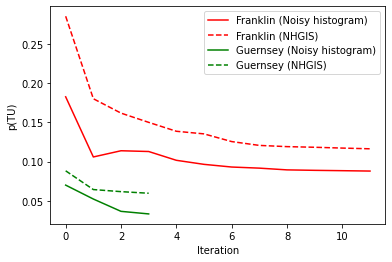

In [138]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_all), color = 'r', label='Franklin (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
plt.plot(np.array(p_tu_all_g), color = 'g', label='Guernsey (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

######**Random**

Randomly sample 10% of the blocks (without replacement) and add  to the histogram.

In [141]:
import scipy.stats

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

data_block_new = data_block
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu_all = []
p_tu_all_nhgis = []

while len(block_ids_all) < len(data_block):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    # create histogram
    data_people_sub = data_people[data_people["GEOID10"].isin(block_ids_all)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all.append(p_tu)

    ## NHGIS
    # create histogram
    nhgis_sub = nhgis_block[nhgis_block["GEOID10"].isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis.append(p_tu_nhgis)
    # print(len(block_ids_all))

p_tu_all, p_tu_all_nhgis

([0.09339451084211853,
  0.08850579664291902,
  0.08850862194888134,
  0.08781618066906273,
  0.086973722249013,
  0.08675513976270187,
  0.0875929481390732,
  0.08746029106889963,
  0.08787696322641826,
  0.08791063281862686,
  0.08792193110751202],
 [0.12008501594048884,
  0.11488673139158576,
  0.1180731618978631,
  0.11498637602179837,
  0.11564477416539384,
  0.11646297627606039,
  0.11593096074537956,
  0.1154308617234469,
  0.11641720123544785,
  0.11636167922497309,
  0.11636167922497309])

Compare with Guernsey county.

In [144]:
import scipy.stats
import geopandas as gpd

filename_block_g = 'guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)

filename_nhgis_block = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

data_block_new = data_block_g
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu_all_g = []
p_tu_all_nhgis_g = []

while len(block_ids_all) < len(data_block_g):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    # create histogram
    data_people_sub = data_people_g[data_people_g["GEOID10"].isin(block_ids_all)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all_g.append(p_tu)

    ## NHGIS
    # create histogram
    nhgis_sub = nhgis_block[nhgis_block["GEOID10"].isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis_g = n_tu / n_u
    p_tu_all_nhgis_g.append(p_tu_nhgis_g)
    # print(len(block_ids_all))

p_tu_all_g, p_tu_all_nhgis_g

([0.03794089999238389,
  0.034125706994759634,
  0.0335321661769337,
  0.031986210689234594,
  0.03255011918636419,
  0.03240063380669271,
  0.032790748021858364,
  0.03250606918352734,
  0.03285335967071572,
  0.033109139223050275,
  0.03317121400234159],
 [0.08620689655172414,
  0.07936507936507936,
  0.07777777777777778,
  0.058333333333333334,
  0.04838709677419355,
  0.04878048780487805,
  0.05128205128205128,
  0.055441478439425054,
  0.05197132616487455,
  0.05967741935483871,
  0.05958132045088567])

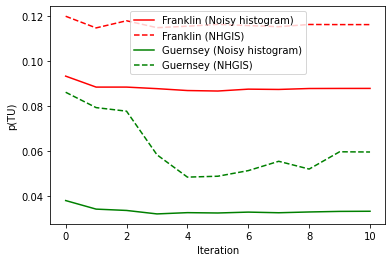

In [145]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_all), color = 'r', label='Franklin (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
plt.plot(np.array(p_tu_all_g), color = 'g', label='Guernsey (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

#####**Impact of privacy loss budget**

In [146]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 17.14 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * math.sqrt(eps * math.log(1 / delta))
eps, eps0, sigma

(0.03765194044422748, 1.8998742342553376, 3.6441086797038675)

In [147]:
import scipy.stats

hist1 = pd.crosstab(data_people.GEOID10, data_people.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.08792193110751202

**Something to do with population density**

The trend above can potentially be explained by the population distribution in the county. As the iteration increases, more sparse blocks are added, and the histogram is more concentrated around zero. This can lead to the sharpe decrease in $p(TU)$.

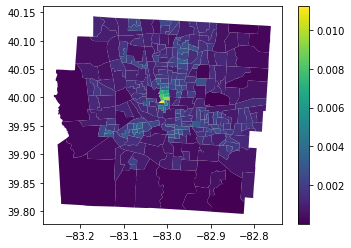

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
data_tract_new.plot(column='POP_DEN', ax=ax, legend=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


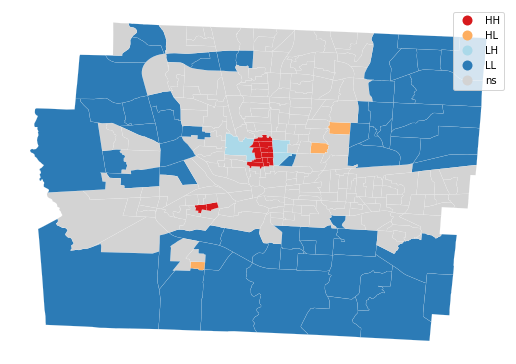

In [ ]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_tract_new['POP_DEN'] = data_tract_new['POP_DEN'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_tract_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_tract_new['POP_DEN'].values, w)
lisa_cluster(moran_loc, data_tract_new, p=0.05, figsize = (9,9))
plt.show()

####**Check noise distribution**

/content/gdrive/My Drive/Colab Notebooks/census_privacy


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


-0.005146899111333566 2.8233444076974767


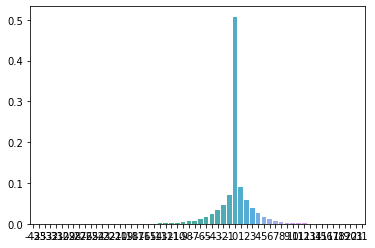

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
-0.015388805665259431 1.431502015562092


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


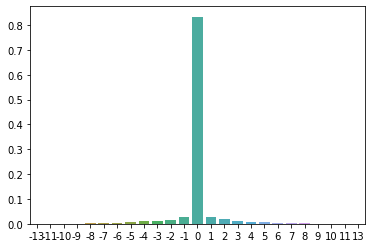

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)

/content/gdrive/My Drive/Colab Notebooks/census_privacy


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.00016105653084232566 7.852655417580383


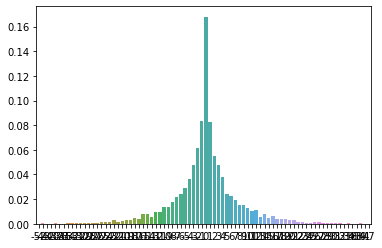

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_bg.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
-0.008928571428571428 3.903971274123783


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


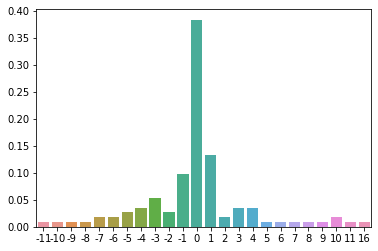

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'guernsey/nhgis/guernsey_nhgis_bg.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
0.0005030181086519115 4.924020268246625


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


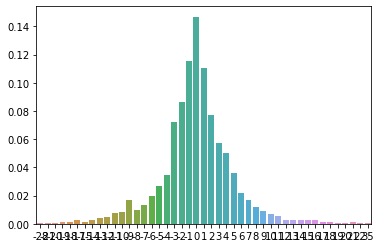

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_tract.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)

/content/gdrive/My Drive/Colab Notebooks/census_privacy
-0.02857142857142857 8.600616968851591


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


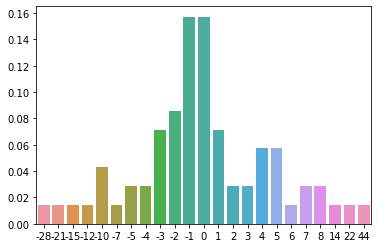

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm

filename_nhgis_block = 'guernsey/nhgis/guernsey_nhgis_tract.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

noise = hist2_nhgis - hist1_nhgis

probabilities = noise.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values)

data = noise.values.ravel()
mu, std = norm.fit(data)
print(mu, std)